In [1]:
# IMPORT VARIABLES, LIBRARIES AND FUNCTIONS
%matplotlib inline

from analysis_funk import * # Stored functions and variables to plot the map of Paris
from mvp_funk import * 


data = mybar_data
print(data.shape)

(40363, 39)


# Get map of things to see in Paris

---

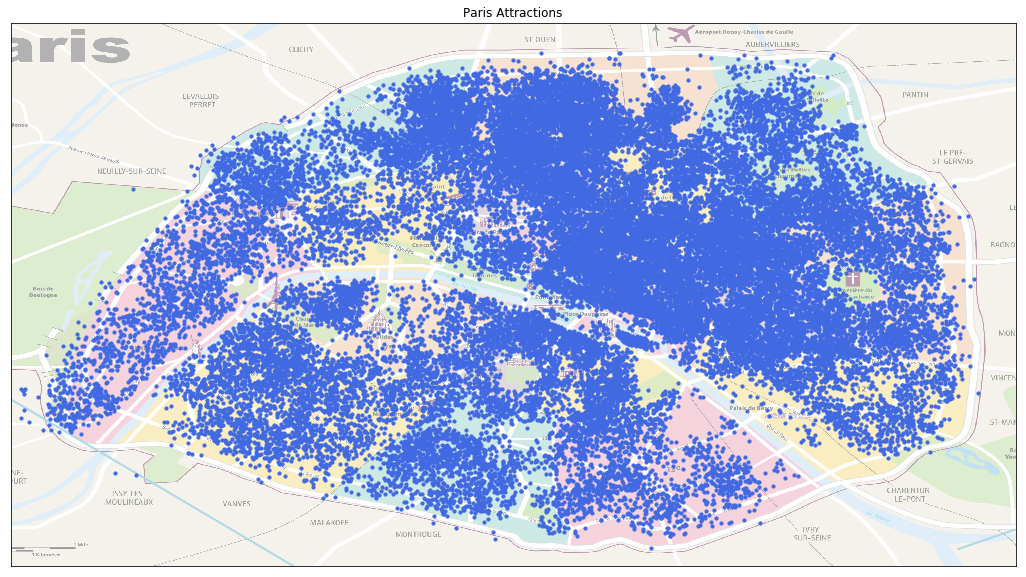

In [2]:
#coord = data.loc[:,['longitude','latitude','zipcode']]
print_map(paris_attractions, res = 'c', arrn_lim = False, title_map='Paris Attractions', l_size=10, l_color = 'royalblue', l_alf=1)
    

---
# Initial Research Findings

### Getting the Occupancy rate:

Airbnb guests may leave a review after their stay, and these can be used as an indicator of airbnb activity (although not all guests leave a review, so the actual booking activity would be much higher). The occupancy rate according to Airbnb would be: 

>***Occupancy_rate = MAX(average_length_of_stay, minimum_nights)x(number_of_reviews)***

An average length of stay is configured for each city, and this, multiplied by the estimated bookings for each listing over a period gives the occupancy rate. For Paris, the average_length_of_stay is set to 3 nights/booking 

**Things to consider:**

- The listing's ancienty. A listing that just started in Airbnb is less likely to have as much reviews as an older listing. There's at least 7000 listings whose first review dates from this year! 

*To counteract the ancienty vs new listings bias, I will normalize the occupancy rate per month and assign its average rate as such. The dataset provides a column called reviews per month.*

- The availability.  A listing with a high availability is susceptible to get more reviews and thus increasing its occupancy rate. An Airbnb host can setup a calendar for their listing so that it is only available for a few days or weeks a year. Other listings are available all year round (except for when it is already booked). This poses a problem as the availability cannot be considered an accurate measure since it can either show the number of days the listing is supposed to be available but it can also show the remaining days a listing hasn't yet been booked thus lowering its availability.

***SCENARIO 1: ***The availability column means the number of days the listing is available per year, set by the host.

If the availability column is considered, then those listings with 0 days available will have to be removed or their value set to a non-zero one. There are 13045 listings that have no availability available, aside from that, the average availability is 145 days. 

Airbnb divides these listings in two categories: High availability for those listings with more than 120 days available and low availability for the rest. In this analysis I will not categorize the listings in these two broad groups but simply assign a weight proportional to its own availability. 

Then the occupancy rate has to be capped by:

> *** occupancy_rate <= min(1, (min_nights x booking_per_year)/days_available)***

.. since the term *(min_nights x booking_per_year)/days_available* can be higher than 1 and therefore not fair for listings with low availability. 

In this scenario the occupancy rate distribution is boxplotted below: 

# *Choosing scenario 2 since the availability on scenario 1 doesnt have much of a discrimination power (since the median is the same as its 75% and 100% percentiles)*

In [154]:
from bisect import bisect
orate_dico = {0:5, 0.2:10, 0.4:15, 0.8:20, 0.9:25, 0.925:30, 0.95:35, 0.975:40, 1:75}
orate = [0, 0.2, 0.4, 0.8, 0.9, 0.925, 0.95, 0.975, 1]


def get_interval_on_rate(o_rate):
    main_intrvl = orate[bisect(orate, o_rate)-1]
    return orate_dico[main_intrvl]

o_rate = data.loc[(data.zipcode<76000)&(data.occupancy_rate<1),['longitude','latitude','zipcode','occupancy_rate']]
#o_rate ['interval_o_rate'] = o_rate.occupancy_rate.apply(get_interval_on_rate)

In this scenario the rate averages 0.752 and the median is 1. 

***SCENARIO 2*** The availability column refers to the days of the year that remain available and therefore there is no value in this variable as it doesnt describe the availability. The occupancy rate will be the one defined by Airbnb in the first case: 

> *Average occupancy_rate per year = min_nights x bookings per year = 12 x min_nights x reviews_per_month*

where basically says that the higher the average of bookings (reviews) per year, the higher the rate and thus the minimum nights can be removed as it is just a constant. The distribution yielded: 

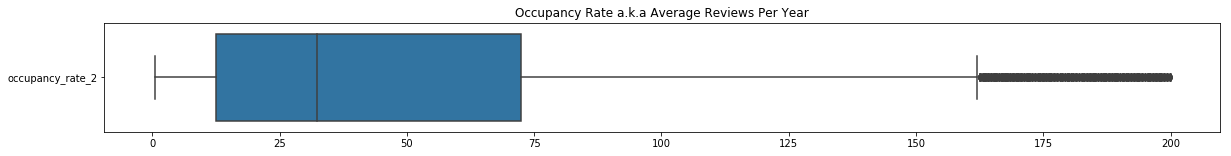

In [50]:
data['occupancy_rate_2'] = [rpm*12*4.5 for rpm in data.reviews_per_month]
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=data.loc[data.occupancy_rate_2<200,['occupancy_rate_2']], orient="h")
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()

In [51]:
fig.savefig('../images/PROJ_Occupancy_rate_scenario_2.png', bbox_inches='tight')

---

#### How can a grading system be implemented using the following parameters: 
- HOST_RESPONSE_TIME: It's a categorical variable holding 4 unique values: 'within an hour', 'within a day', 'within a few hours','a few days or more'.
- HOST_SUPERHOST: Boolean
- ROOM_TYPE
- BED_TYPE
- BATHROOMS
- AMENITIES

#### Knn for every attraction or for every cluster of attractions? 
- Every attraction will have its neighbor listing (listing_id) and its distance. 
- How can n be optimized? or a threshold in the distance can set it. 
- The distance might not vary drastically as there are a lot of listings pretty much everywhere. So defining a threshold might be difficult. 
- How will repeated listings be handled? Two or more attractions may have the same listing near. Can that be rewarded?  

#### KNN for every listing and its n (~20, 40, 60) nearest attractions
- Can there be a ranking of every listing and it's average distance to its n nearest attractions? Like the listing with the smallest average (or 1st quartile) distance will be the best listing in terms of location. 

#### What is the proportion of listings per district?
- What is the average PRICE of listings per district? Are there districts that can be considerably high or low? Consider the space
- What is the occupancy rate per district? 
- What is the proportion of attractions per district? Does it correlate with the average price of the district? 

___

# Further Research and Analysis

Analyze more the occupancy rate. Listings (old and new) which have availability only in the high season vs those available in both seasons. 

There is room to implement association rules in variables such as amenities and host_verifications. 
What are rare amenities and which ones are the most common? are most rare amenities considered luxurious? which of them can be considered as such? Which categories can be considered luxurious?

Im curious what do listings that have 0 amenities, have to offer... do they have a non-null value for the accomodates and guest_included values?



NLP: What is the evolution of good reviews for a particular listing? Is there an associative rule? 

Is Paris visited mostly by romantic couples or party animals?
    - Check the house_rules

Time series?? 

Sense of space? How spatious are the listings? Can we define it using some of these columns? Like # of beds and bathrooms, amenities etc... 

Fairness of the judgement. There is some inequality here as the listings ancienty is not very well considered here. 

# Appendix
1. This is the format of the html code scraped to get the coordinates of some of the tourist attractions in Paris. 

https://latitude.to/map/fr/france/cities/paris
<ul>
<li>
    <article>
    <h3 class="title">
        <a href="/map/fr/france/cities/paris/articles/6/eiffel-tower" title="GPS Coordinates of Eiffel Tower">Eiffel Tower</a>
    </h3>
    <p>The 
        <b>Eiffel Tower</b> (French: <span lang="fr" xml:lang="fr">
        <b>La tour Eiffel</b></span>, 
        <span title="Representation in the International Phonetic Alphabet (IPA)">[tuʁ ɛfɛl]</span>) is an iron lattice tower located on the Champ de Mars in Paris, France. It was named after the engineer Alexandre Gustave Eiffel, whose company designed and built the tower. Erected in 1889 as th…
    </p>
    <div class="act">
        <a class="show" data-lat="48.8583" data-center-idx="w0" data-lng="2.2945" href="#lfmap" title="Show Eiffel Tower in map" data-zoom="14">
            <i class="material-icons"></i> Show in map</a>
        <a href="/map/fr/france/cities/paris/articles/6/eiffel-tower" title="GPS Coordinates of Eiffel Tower, France">
            <i class="material-icons"></i> Show coordinates</a>
    </div>
    </article>
</li>


